In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Position of detection stations
R = np.zeros((6,3))
R[0] = np.array([2.0 ,20.0 ,0.0])
R[1] = np.array([-2.0,-1.0 ,0.0])
R[2] = np.array([5.0 ,12.0 ,0.0])
R[3] = np.array([8.0 ,10.0 ,0.0])
R[4] = np.array([5.0 ,-16.0,0.0])
R[5] = np.array([1.0 ,40.0 ,0.0])
# Times of arrival
T = np.array([3.23,3.82,2.27,3.04,5.65,6.57])
print(R,T)

[[  2.  20.   0.]
 [ -2.  -1.   0.]
 [  5.  12.   0.]
 [  8.  10.   0.]
 [  5. -16.   0.]
 [  1.  40.   0.]] [ 3.23  3.82  2.27  3.04  5.65  6.57]


In [70]:
# Uncertainty in time, declared velocity
sigmat = 0.05
v      = 5.0

(-10, 40)

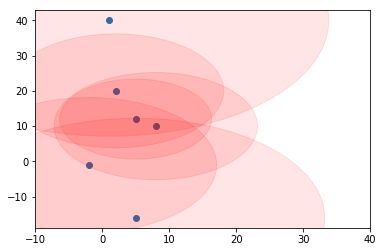

In [80]:
fig, ax = plt.subplots()
ax.scatter(R.T[0],R.T[1])
for i in range(6):
    circle1 = plt.Circle((R[i][0],R[i][1]), v*T[i], color='r',alpha= 0.1)
    ax.add_artist(circle1)
#plt.Circle((R-10-[0],R.T[1]), v*T[i], color='r')
ax.set_xlim(-10,40)


Let us take the most simple model for the propagation of the sismic wave:

$\left|\vec{r}-\vec{r}_0\right| = vt$

Where $\vec{r}$ is the position in which the wave is detected, $\vec{r}_0$ is the epicenter and $t$ is the time of arrival.

This leads us to the theoretical model for the time:
$t = \left|\vec{r}-\vec{r}_0\right|/v$

Which defines the $\chi^2$:

$$\chi^2= \frac{1}{2}\sum \frac{(t_{obs} -t_{theo})^2}{\sigma_t} = \sum \frac{\left(t_{obs} -\frac{\left|\vec{r_{obs}}-\vec{r}_0\right|}{v}\right)^2}{\sigma_t}$$

With this, Hamiltonian is defined with potential related to -log(likelihood)


In [298]:
# Structure of code from: 
#https://github.com/ComputoCienciasUniandes/MetodosComputacionalesAvanzados/blob/master/weeks/09/hamiltoniano.ipynb 
# x,y,z is r0
def likelihood(epiR):
    x,y,z = epiR
    like = np.exp(-(0.5/sigmat)*np.sum( (T - (1.0/v)*(np.sqrt((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2)))**2))
    if(z<0):
        return like
    return 0
def loglikelihood(epiR):
    x,y,z = epiR
    loglike = -(0.5/sigmat)*np.sum( (T - (1.0/v)*(np.sqrt((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2)))**2)
    if(z<0):
        return loglike
    return -inf
# vector
def gradient_loglikelihood(epiR):
    x,y,z = epiR
    #print(x,y,z)
    return np.array([np.sum(-(1.0/v)*(T - (1.0/v)*(np.sqrt((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2)))
            *(1.0/(np.sqrt((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2)))*(R.T[i]-epiR[i])) for i in range(3)])
# epiR, epiP are vectors
def leapfrog(epiR,epiP, delta_t=0.5E-1, niter=5):
    epiR_new = epiR.copy()
    epiP_new = epiP.copy()
    for i in range(niter):
        epiP_new = epiP_new + 0.5 * delta_t * gradient_loglikelihood(epiR_new)
        epiR_new = epiR_new + delta_t * epiP_new
        epiP_new = epiP_new + 0.5 * delta_t * gradient_loglikelihood(epiR_new)
    return epiR_new, epiP_new

def H(epiR,epiP):
    K = 0.5 * np.linalg.norm(epiP)**2
    U = -loglikelihood(epiR)
    return K + U

## HAMILTONIAN MCMC IS NOW PREPARED ##

In [299]:
def MCMC(nsteps):
    epiR = np.zeros((nsteps,3))
    epiP = np.zeros((nsteps,3))
    # Defines sigmap and sigmar
    sigmar = [1,1,1]
    sigmap = sigmar
    epiP[0] = np.array([np.random.normal(0,sigmap[0]),np.random.normal(0,sigmap[1]),np.random.normal(0,sigmap[2])])
    epiR[0] = np.array([np.random.normal(0,sigmar[0]),np.random.normal(0,sigmar[1]),np.random.normal(0,sigmar[2])])
    for i in range(1,nsteps):
        epiP[i] = np.array([np.random.normal(0,sigmap[0]),np.random.normal(0,sigmap[1]),np.random.normal(0,sigmap[2])])
        epiR_new, epiP_new = leapfrog(epiR[i-1],epiP[i-1])
        E_new = H(epiR_new, epiP_new)
        E_old = H(epiR[i-1], epiP[i-1])
        alpha = min(1.0,np.exp(-E_new + E_old))
        beta = np.random.random()
        if beta < alpha:
            epiR[i] = epiR_new
        else:
            epiR[i] = epiR[i-1]
    return epiR

In [300]:
epiR_chain = MCMC(5000)[500:]


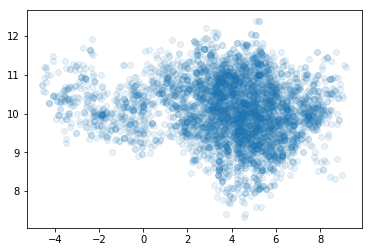

In [302]:
scatter(epiR_chain.T[0],epiR_chain.T[1],alpha=0.1)

In [303]:
len(epiR_chain.T[1])

4500

(-10, 40)

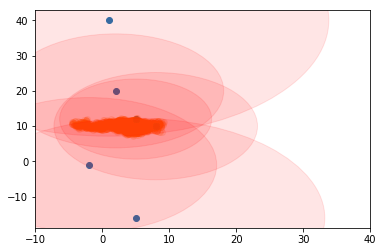

In [304]:
fig, ax = plt.subplots()
ax.scatter(R.T[0],R.T[1])
for i in range(6):
    circle1 = plt.Circle((R[i][0],R[i][1]), v*T[i], color='r',alpha= 0.1)
    ax.add_artist(circle1)
#plt.Circle((R-10-[0],R.T[1]), v*T[i], color='r')
scatter(epiR_chain.T[0],epiR_chain.T[1],alpha=0.1)
ax.set_xlim(-10,40)


## Reasonable (Circles define the predicted epicenter-surface for each station)  ##

## Distributions ##

In [305]:
Xs,Ys,Zs = epiR_chain.T
# As defined on 
#https://github.com/ComputoCienciasUniandes/MetodosComputacionalesAvanzados
#/blob/master/weeks/08/RubinGelmanTest.ipynb
def norm_hist(l_walk):
    y, x = np.histogram(l_walk, bins=50)
    x = 0.5*(x[1:]+x[:-1])
    normh = np.sum(y * (x[1]-x[0]))
    return x, y/normh


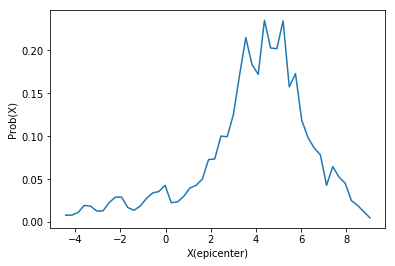

In [306]:
fig, ax = plt.subplots()
h1,h2 = norm_hist(Xs)
ax.plot(h1,h2)
ax.set_ylabel("Prob(X)")
ax.set_xlabel("X(epicenter)")

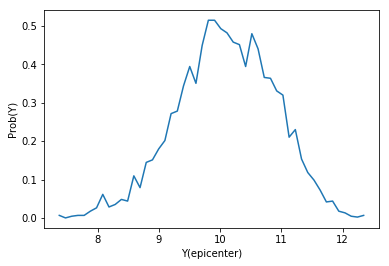

In [307]:
fig, ax = plt.subplots()
h1,h2 = norm_hist(Ys)
ax.plot(h1,h2)
ax.set_ylabel("Prob(Y)")
ax.set_xlabel("Y(epicenter)")

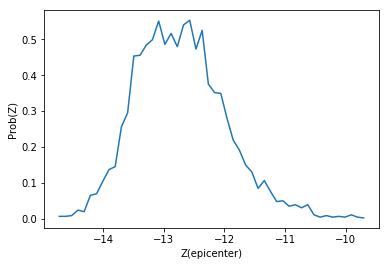

In [308]:
fig, ax = plt.subplots()
h1,h2 = norm_hist(Zs)
ax.plot(h1,h2)
ax.set_ylabel("Prob(Z)")
ax.set_xlabel("Z(epicenter)")

## RUBIN ##

In [311]:
def gelman_rubin( N=2000, M=4):
    walks = {}
    for m in range(M):
        walks[m] = MCMC(N)
    
    R = np.zeros((N-1,3))
    for i in range(N-1):
        n = i+1
        mean_walks = np.zeros((M,3))
        variance_walks = np.zeros((M,3))
        mean_general = np.zeros(3)
        for k in range(3):
            for m in range(M):
                mean_walks[m][k] = (walks[m][:,k])[:n].mean()
                variance_walks[m][k] = (walks[m][:,k])[:n].std() ** 2
            mean_general[k] = mean_walks[:,k].mean()    
        B = np.zeros(3)
        W = np.zeros(3)
        for k in range(3):
            for m in range(M):
                B[k] += (mean_walks[m][k] - mean_general.T[k].T)**2
            W[k] = variance_walks[:,k].mean()
            B[k] = n*B[k]/(M-1)
        
        for k in range(3):
            R[n-1][k] = (n-1)/n + (B[k]/W[k])*(M+1)/(n*M)
    
    return walks, R

In [312]:
epiR,R_GR = gelman_rubin()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in double_scalars


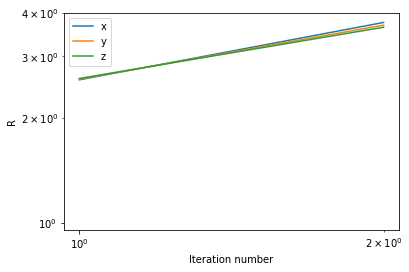

In [313]:
fig, ax = plt.subplots()
ax.set_ylabel("R")
ax.set_xlabel("Iteration number")
plt.loglog()
ax.plot(R_GR[100:][0], label = 'x')
ax.plot(R_GR[100:][1], label = 'y')
ax.plot(R_GR[100:][2], label = 'z')
ax.legend()

In [314]:
R_GR

array([[         inf,          inf,          inf],
       [ 29.89732644,  15.611632  ,  65.22509994],
       [ 35.92804888,   9.56235665,  50.7214117 ],
       ..., 
       [  1.03571078,   1.08901934,  15.18008954],
       [  1.03570854,   1.08854217,  15.18439568],
       [  1.03570011,   1.08805948,  15.18829498]])